In [1]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings(action='ignore')

#Visulization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

#Machine Learning
import lightgbm as lgb
import xgboost as xgb
import catboost as cb
from sklearn.linear_model import LogisticRegression

#Evaluation
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score, average_precision_score 
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve

#HyperParameters
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from bayes_opt import BayesianOptimization

# F2 score for gridSearchCV
from sklearn.metrics import fbeta_score
from sklearn.metrics import make_scorer

## 데이터 준비

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
t_data = pd.read_csv(r'C:\Users\김상휘\Desktop\Hwi\한이음-kt\data\telecom_data.csv', encoding='euc-kr',engine='python')
t_data.rename(columns= t_data.iloc[0],inplace=True)
t_data.drop(t_data.index[0],axis=0,inplace=True)

In [4]:
t_data['Churn'].value_counts()

No     5174
Yes    1869
Name: Churn, dtype: int64

# 1. 전처리

## 1-1. 결측치 처리

In [5]:
t_data['TotalCharges'] = t_data['TotalCharges'].replace(" ",np.nan)
t_data.dropna(inplace=True)
t_data.drop('customerID',axis=1,inplace=True)

## 1-2. 타입 변경하기

In [6]:
col1 = ['MonthlyCharges','TotalCharges']
for i in col1:
    t_data[i] = t_data[i].astype(float)

t_data['tenure'] = t_data['tenure'].astype(int)
t_data.dtypes

gender               object
SeniorCitizen        object
Partner              object
Dependents           object
tenure                int32
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                object
dtype: object

## 1-3. 이탈 = 1 / 이탈하지 않음 = 0

In [7]:
t_data.loc[t_data.Churn == 'No','Churn'] = 0
t_data.loc[t_data.Churn == 'Yes', 'Churn'] = 1
t_data.Churn = t_data.Churn.astype(int)

# 2. EDA

## 2-1. 특성별 빈도수 파악

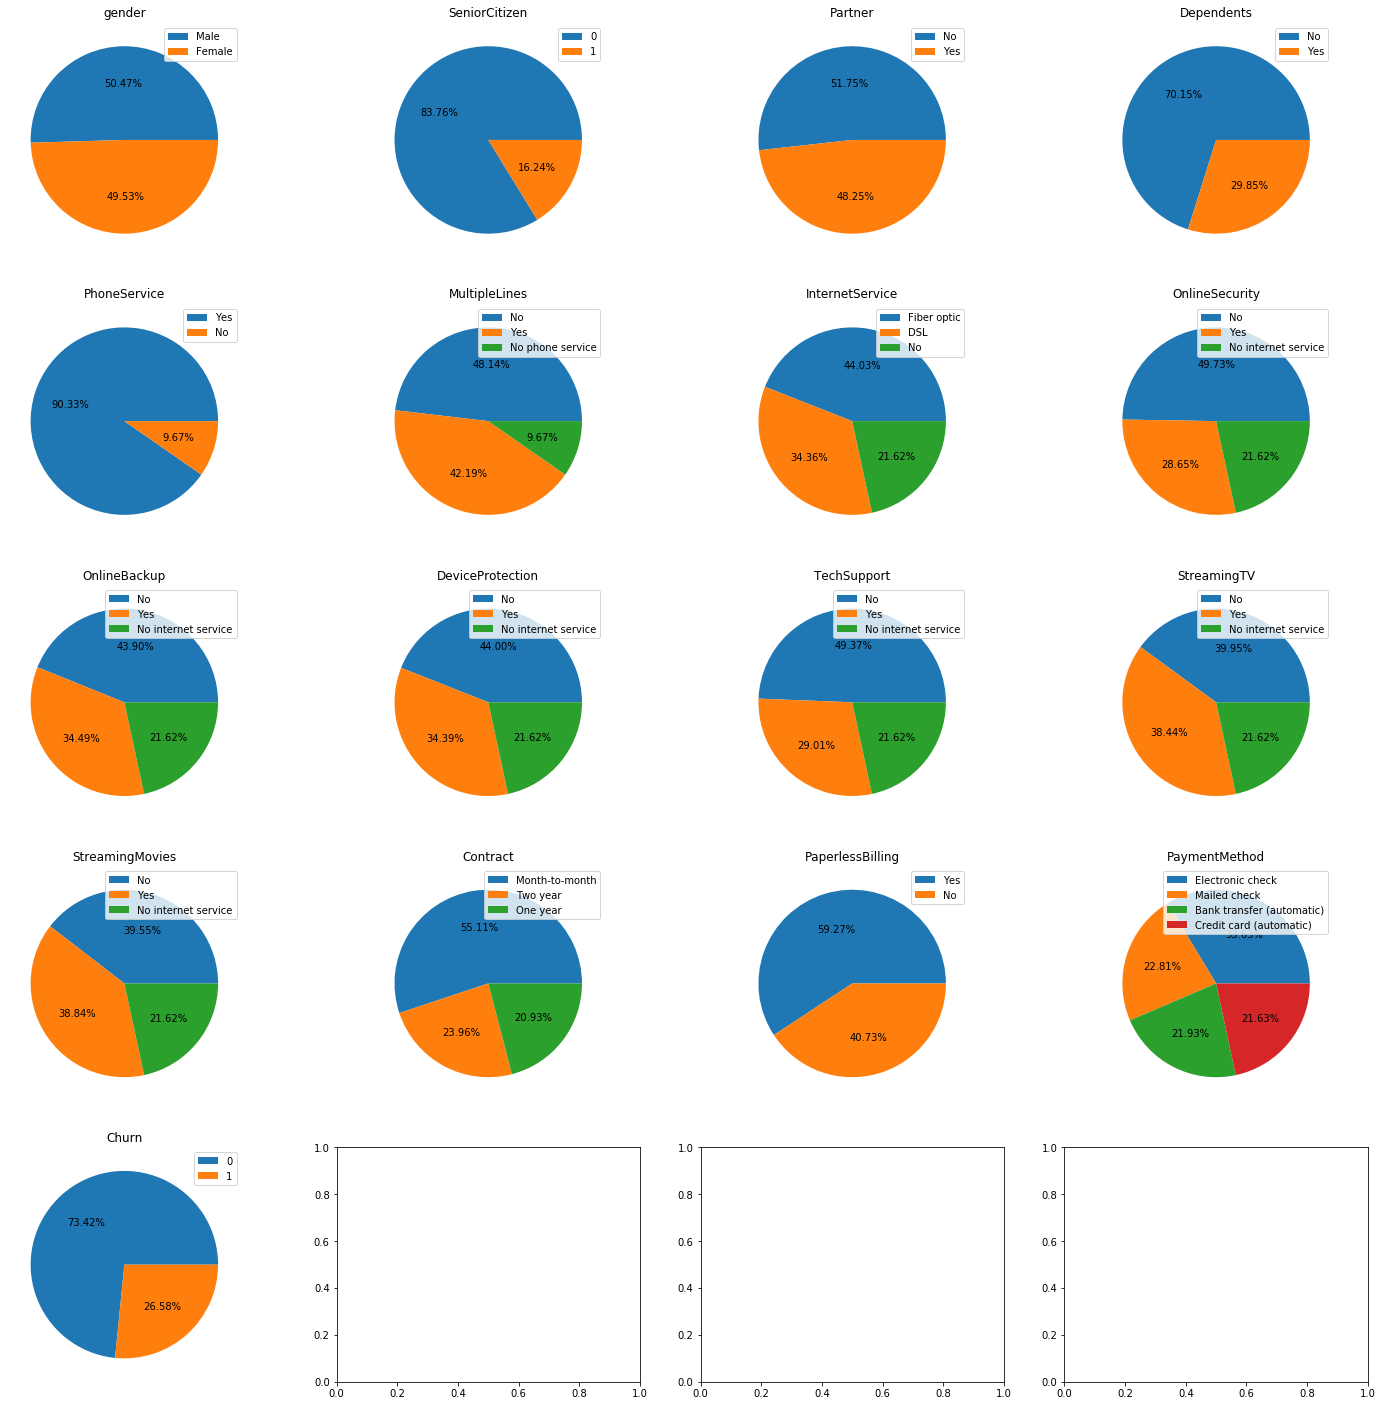

In [8]:
import math

columns = t_data.columns.tolist()
dellist = ['tenure','MonthlyCharges','TotalCharges']
for i in dellist:
    columns.remove(i)
    
f, axes = plt.subplots(math.ceil(len(columns)/4),4, figsize=(25,25))
for col, ax in zip(columns, axes.ravel()):
        data = t_data[col].value_counts().values.tolist()
        labels = t_data[col].value_counts().index.tolist()
        ax.pie(data,autopct='%0.2f%%')
        ax.set_title(col)
        ax.legend(labels,loc='best')

## 2-2. 특성별 이탈율 파악

#### 2-2-1. 카테고리형

In [9]:
import plotly.graph_objects as go
import plotly.offline as pyoff

def cat_plot(col):
    df_plot = t_data.groupby(col).Churn.mean().reset_index()

    plot_data = go.Bar(x = df_plot[col],
                       y = df_plot['Churn'],
                       width = 0.5,
                      marker=dict(color=['green','blue','orange','red']))

    plot_layout = go.Layout(xaxis = {'type':'category'},
                           yaxis = {'title':'Churn Rate'},
                           title = col,
                           plot_bgcolor = 'rgb(243,243,243)',
                           paper_bgcolor = 'rgb(243,243,243)')

    fig = go.Figure(data = plot_data,layout = plot_layout)
    pyoff.iplot(fig)

columns.remove('Churn')
for i in columns:
    cat_plot(i)

#### 2-2-2. 연속형

In [10]:
def num_plot(cols):
    df_plot = t_data.groupby(cols).Churn.mean().reset_index()

    plot_data = go.Scatter(x = df_plot[cols],
                          y = df_plot['Churn'],
                          mode = 'markers',
                          marker = dict(size = 7,
                                        line= dict(width=1), 
                                        color = 'blue',
                                       opacity = 0.8 ))

    plot_layout = go.Layout(xaxis = {'title':cols},
                           yaxis = {'title':'Churn Rate'},
                           title = cols + ' based Churn rate',
                           plot_bgcolor = 'rgb(243,243,243)',
                           paper_bgcolor = 'rgb(243,243,243)')

    fig = go.Figure(data=plot_data, layout=plot_layout)
    pyoff.iplot(fig)

cols = ['tenure','MonthlyCharges','TotalCharges']
for i in cols:
    num_plot(i)

## 2-3. 상관관계 행렬

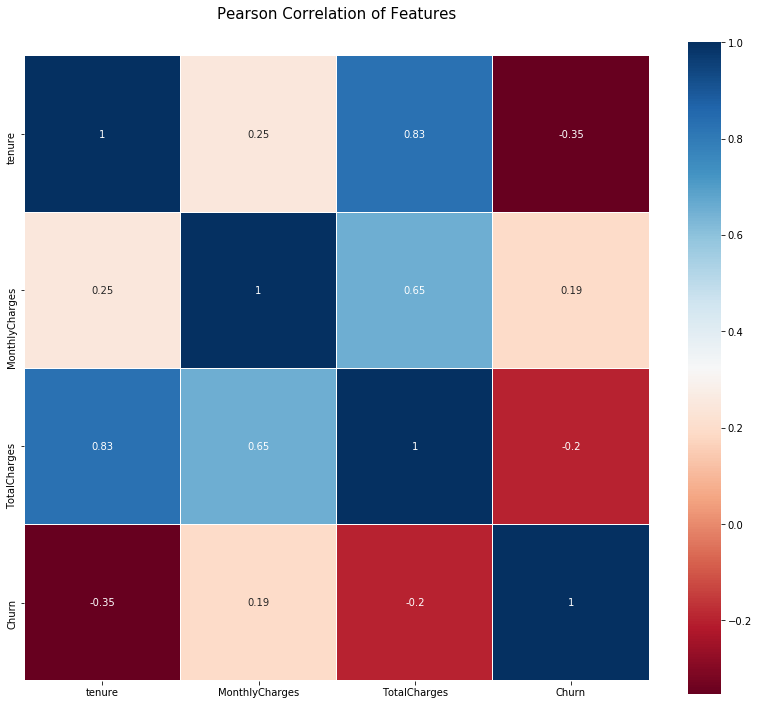

In [11]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(t_data.corr(),linewidths=0.1, vmax=1.0,square=True, cmap=colormap, linecolor='white', annot=True)

## 2-4. EDA 결과

선택지가 두 개인 특성(13개)
이탈률이 더 높은 label을 df에 기록함
고령자일수록, 청구서를 직접 받을수록, 온라인보안서비스를 신청하지 않았을수록 이탈률이 높음

선택지가 3개 이상(3개)
cat_plot을 통해 확인
Internet Service : 광섬유가 가장 이탈률이 높고 서비스를 신청하지 않은게 가장 이탈률이 낮음
Contract : 계약기간이 짧을수록 이탈률이 높음
PaymentMethod : 직접 계산할수록 이탈률이 높음

연속형 특성(3개)
tenure : 남은기간이 짧을수록 이탈률 높음
MontlyCharges : 이탈률과 선형적 관계없음
TotalCharges : 이탈률과 선형적 관계없음

상관행렬을 통한 인사이트
total charges와montly charges와 tenure 사이에 밀접한 관계가 있음
실제로 확인해본 결과, 식을 발견했음
total charges = montly charges * tenure 

# 3. 특성공학

## 3-1. 데이터 스케일링 - tenure, monthly, total charges - MinMax

#### tenure

(0, 1)

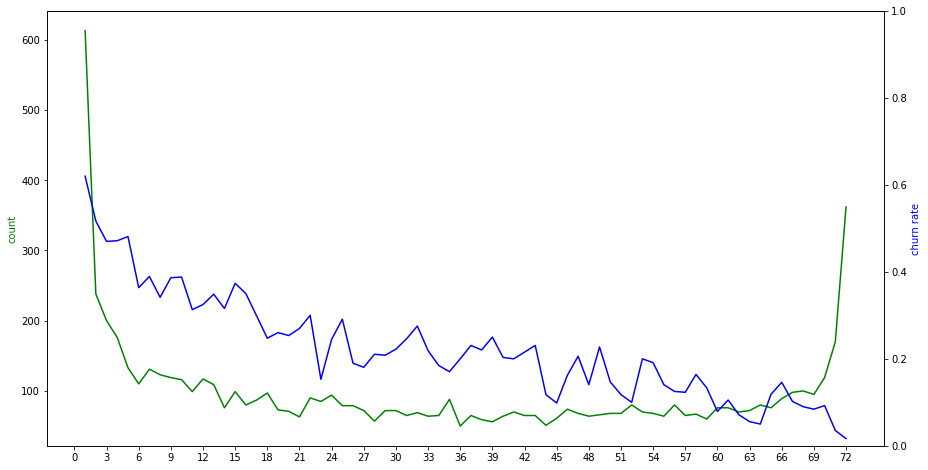

In [12]:
t_tenure = t_data.tenure.value_counts().sort_index()
x = t_tenure.index
y1 = t_tenure.values
y2 = t_data.groupby('tenure').Churn.mean().values

fig, ax1 = plt.subplots(figsize = (15,8))

ax2 = ax1.twinx()

ax1.plot(x,y1,'g-')
ax2.plot(x,y2,'b-')

ax1.set_xticks(range(0,73,3))
ax1.set_ylabel('count', color='g')
ax2.set_ylabel('churn rate', color='b')
ax2.set_ylim((0,1))

In [13]:
tenu = np.array(t_data.tenure).reshape(-1,1)
scaler = MinMaxScaler()
a = scaler.fit_transform(tenu)
t_data['tenure'] = a

#### Monthly Charges

In [14]:
monthly = np.array(t_data.MonthlyCharges).reshape(-1,1)
scaler = MinMaxScaler()
a = scaler.fit_transform(monthly)
t_data['MonthlyCharges'] = a

#### Total Charges

In [15]:
total = np.array(t_data.TotalCharges).reshape(-1,1)
scaler = MinMaxScaler()
a = scaler.fit_transform(total)
t_data['TotalCharges'] = a

## 3-2. 원 핫 인코딩

In [16]:
t_data_dummies = t_data.drop('Churn',axis=1)
t_data_dummies = pd.get_dummies(t_data_dummies)
t_data_dummies['Churn'] = t_data['Churn']

In [17]:
#t_data_dummies.to_csv(r'C:\Users\김상휘\Desktop\Hwi\한이음-kt\data\data_Hwi.csv',index=False)

# 4. 모델링

In [18]:
data = t_data_dummies.drop('Churn',axis=1)
target = t_data_dummies.Churn

seed = 77
X_train_val, X_test, y_train_val, y_test = train_test_split(data,target,random_state = seed)
X_train, X_val, y_train, y_val = train_test_split(X_train_val,y_train_val,random_state = seed)

## 4-1. 로지스틱 회귀

#### 4-1-1. 학습 및 예측

In [19]:
model = LogisticRegression().fit(X_train,y_train)

# 이진수로 나타냄
y_pre = model.predict(X_val)

In [20]:
# probability로 나타냄
probs = model.predict_proba(X_val)
y_prob = probs[:,1]

In [21]:
# probabiliy를 이진수로 바꾸기
#for i in range(len(y_prob)):
#    if y_prob[i]>=0.5:
#        y_prob[i] = 1
#    else:
#        y_prob[i] = 0

#### 4-1-2. 모델 평가 (Validation set) 지표

##### - 지표 1. 정확도, 정밀도, 재현율, F1 점수

In [22]:
model_box = pd.DataFrame(columns=['logistic','xgboost','lightgbm','catboost'],
                         index = ['accuracy','precision','recall','f1 score','f1.5 score','f2 score','pr_auc','roc_auc'])

In [23]:
def f_score(beta,y_real, y_pred):
    beta = beta
    pr = precision_score(y_real, y_pred)
    re = recall_score(y_real, y_pred)
    score = (1+beta**2)*(pr*re)/((beta**2*pr)+re)
    return score

In [24]:
def evaluate(y_real,y_pred, y_prob):
    acc = accuracy_score(y_real, y_pred)
    pre = precision_score(y_real, y_pred)
    rec = recall_score(y_real, y_pred)
    f1 = f1_score(y_real, y_pred)
    f2 = f_score(1.5,y_real, y_pred)
    f3 = f_score(2,y_real, y_pred)
    auc1 = average_precision_score(y_real, y_prob)
    auc2 = roc_auc_score(y_real, y_prob)
    print('Accuracy : {:.6f}'.format(acc)) #정확도 : 예측이 정답과 얼마나 정확한가
    print('Precision : {:.6f}'.format(pre)) #정밀도 : 예측한 것 중에서 정답의 비율
    print('Recall : {:.6f}'.format(rec)) #재현율 : 정답 중에서 예측한 것의 비율
    print('F1 score : {:.6f}'.format(f1)) #정밀도와 재현율의 (조화)평균 - 정밀도와 재현율이 비슷할수록 높은 점수
    print('F1.5 score : {:.6f}'.format(f2))
    print('F2 score : {:.6f}'.format(f3))
    print('PR curve_auc score : {:.6f}'.format(auc1))
    print('ROC curve_auc score : {:.6f}'.format(auc2))
    print('\nConfusion Matrix : \n {}'.format(confusion_matrix(y_real, y_pred, labels = [1,0]))) # labels를 설정해주지 않으면 순서가 바뀜
    
    score_list = [acc,pre,rec,f1,f2,f3,auc1,auc2]
    score_box = np.array(score_list)
    return score_box

In [25]:
def graph_f_score(i,j,k,y_real,y_pred):
    x_range = np.arange(i,j,k)
    score = []
    for kk in x_range:
        score.append(f_score(kk,y_real,y_pred))
    score = np.array(score)
    plt.figure(figsize=(10,5))
    plt.plot(x_range, score,'-o')
    plt.title('F-score by weight')
    plt.xlabel('weight')
    plt.ylabel('f-score')

In [26]:
evaluate(y_val,y_pre,y_prob)

Accuracy : 0.793025
Precision : 0.604240
Recall : 0.515060
F1 score : 0.556098
F1.5 score : 0.539563
F2 score : 0.530726
PR curve_auc score : 0.624304
ROC curve_auc score : 0.839791

Confusion Matrix : 
 [[171 161]
 [112 875]]


array([0.79302502, 0.60424028, 0.51506024, 0.55609756, 0.53956311,
       0.53072626, 0.62430356, 0.83979077])

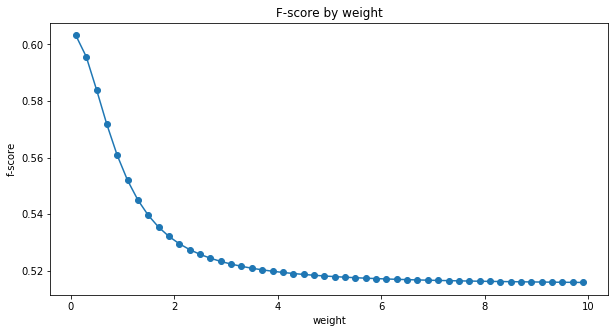

In [27]:
graph_f_score(0.1,10,0.2,y_val,y_pre)

##### 해석 tip

- TP : 양성으로 잘 판단했다
- FN : 음성으로 잘못 판단했다 -> 실제로는 양성이다
- FP : 양성으로 잘못 판단했다 -> 실제로는 음성이다
- TN : 음성으로 잘 판단했다

True / False : 판단 결과

Positive(양성)(1) / Negative(음성)(0) : 나의 추론

- 정밀도 : TP / TP+FP(양성으로 예측한것) : 양성으로 예측한 것 중에 실제 양성인것
- 재현율, 민감도(TPR) : TP / TP+FN(실제 양성인 것) : 실제 양성인 것 중에 양성으로 예측한 것
- 특이도 : TN / FP+TN(실제 음성인 것) : 실제 음성인 것 중에 음성으로 예측한 것
- 1-특이도(FPR) : FP / FP+TN : 실제 음성인 것 중에 양성으로 예측한 것

임계값이 낮다 -> 대부분 양성으로 판단하겠다 -> 재현율(예측양성/실제양성)이 높고, 정밀도(실제양성/예측양성)가 낮다

##### - 지표 2. 정밀도-재현율 곡선

PR curve VS ROC curve

자료1. 
- pr curve에는 TN(실제 음성을 음성으로 판단한 것)이 관여하지 않는다
- 따라서 False(음성)인 것을 판단하는 비중이 적다는 것
- 안그래도 중요성이 적은 False로 치우친 불균형 데이터셋에서 pr curve 사용
- ex. 암 환자 색출 - 음성을 양성으로 판단하는 오류보다, 양성을 음성으로 판단하는 오류에 더 치명적 => 양성 클래스를 집중 탐지해야함

자료2.
- 정밀도는 데이터가 불균형할때 값의 영향을 많이 받음
- 그에 반해, ROC Curve의 TPR과 FPR은 데이터가 불균형해도 모름. 왜냐면 실제 양성인 것 중에 양성, 음성인 것 중에 음성의 비율이라서
- 따라서 데이터가 불균형할때에는 PR curv를 사용함

In [28]:
def plot_pr_curve(y_val, y_prob):
    precisions, recalls, thresholds = precision_recall_curve(y_val, y_prob)
    pr_auc = average_precision_score(y_val, y_prob)
    plt.title('Precision-Recall Curve')
    plt.plot(recalls, precisions, 'b', label = 'AUC = %0.2f' % pr_auc)
    plt.legend(loc = 'lower right')
    b_line = len(y_val[y_val==1]) / len(y_val)
    plt.plot([0, 1], [b_line, b_line], "r--")
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('Precision')
    plt.xlabel('Recall')
    plt.show()

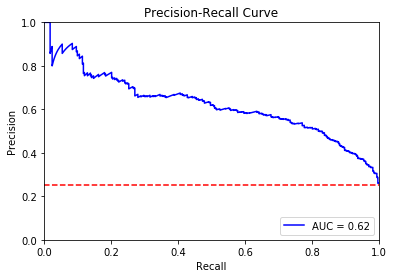

In [29]:
plot_pr_curve(y_val, y_prob)

##### - 지표 3. ROC 곡선

- 양성과 음성의 판단 중요도가 비슷할 경우 사용
- ex. 개와 고양이 분류
- 모든 threshold에 대해 얼마나 잘 예측하는지에 대한 곡선
- 하나의 값으로 비교하기 위해 AUC 개념 도입

In [30]:
def plot_roc_curve(y_val, y_prob):
    fpr, tpr, threshold = roc_curve(y_val, y_prob)
    roc_auc = roc_auc_score(y_val, y_prob)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

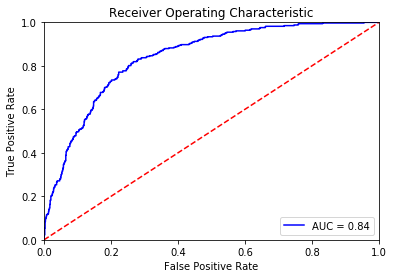

In [31]:
plot_roc_curve(y_val, y_prob)

#### 4-1-3. 최적의 매개변수 구하기

In [32]:
# beta=2인 f score로 최적의 매개변수 찾기
f_two_scorer = make_scorer(fbeta_score, beta = 2)

In [33]:
# 그리드서치 스코어 기준
cri_score = f_two_scorer

In [34]:
penalty = ['l1', 'l2']
C = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
solver = ['liblinear', 'saga']

param_grid = dict(penalty=penalty, C=C, solver=solver)

grid = GridSearchCV(estimator = LogisticRegression(), param_grid=param_grid, scoring=cri_score, verbose=1, n_jobs=-1, cv=5, iid=True)

grid_result = grid.fit(X_train_val, y_train_val)

print('Gridsearch by using AUC')
print('best parameter : {}'.format(grid.best_params_))
print('best AUC score of CV : {:.3f}'.format(grid.best_score_)) # 교차검증의 평균 정확도
print('best AUC score of test set : {:.3f}'.format(grid.score(X_test,y_test))) # 최적의 매개변수와 전체 train 데이터로 만든 모델로 평가한 점수

Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:   10.9s finished


Gridsearch by using AUC
best parameter : {'C': 100, 'penalty': 'l1', 'solver': 'saga'}
best AUC score of CV : 0.561
best AUC score of test set : 0.586


#### 4-1-4. 테스트

In [35]:
y_pred = grid_result.predict(X_test)

probs = grid_result.predict_proba(X_test)
y_prob = probs[:,1]


model_box['logistic'] = evaluate(y_test, y_pred, y_prob)

Accuracy : 0.811149
Precision : 0.673418
Recall : 0.567164
F1 score : 0.615741
F1.5 score : 0.596104
F2 score : 0.585645
PR curve_auc score : 0.659619
ROC curve_auc score : 0.847287

Confusion Matrix : 
 [[ 266  203]
 [ 129 1160]]


#### 4-1-5. 특성 중요도

In [36]:
importance = model.coef_[0]
df = pd.DataFrame(data=importance,index=X_train.columns,columns=['importance'])
df = df.sort_values(by='importance')

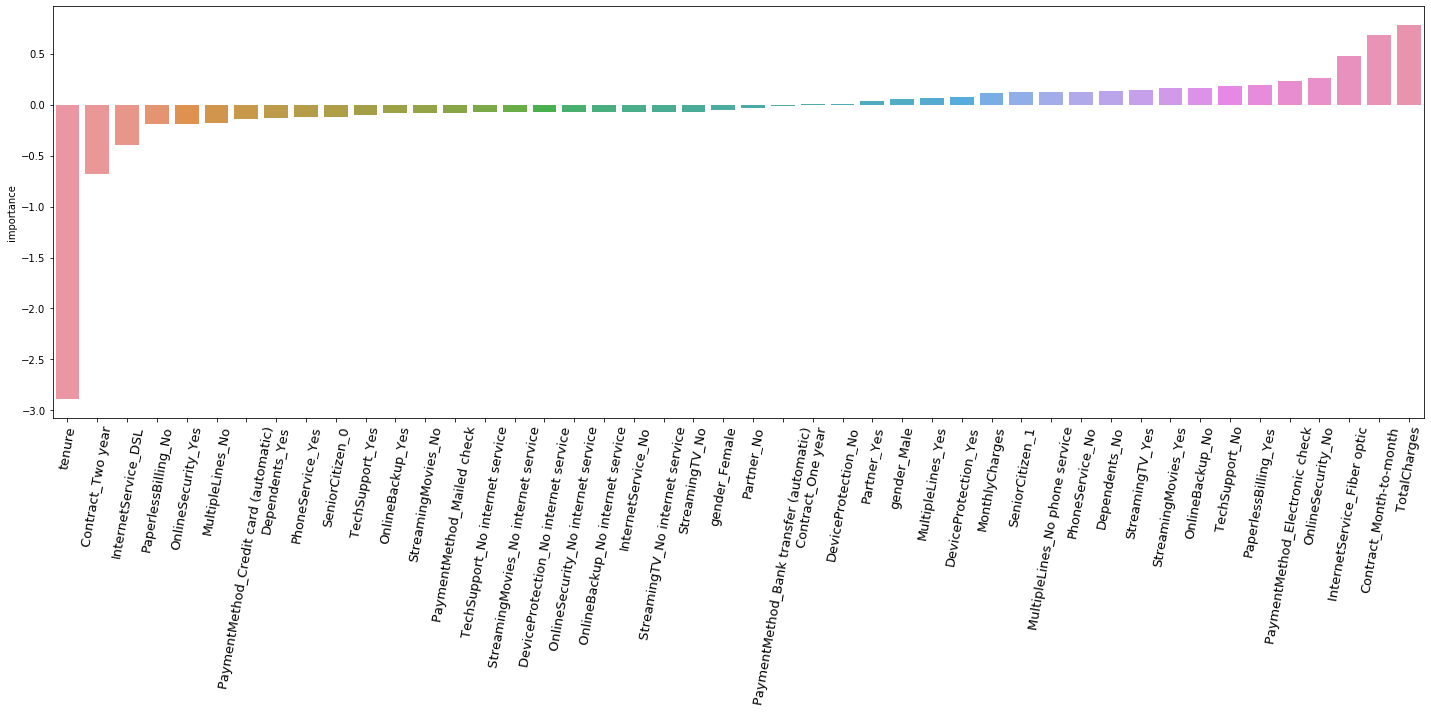

In [37]:
plt.figure(figsize=(20,10))
ax = sns.barplot(df.index,df.importance)
ax.set_xticklabels(df.index,rotation=80,fontsize=13)
plt.tight_layout()
plt.show()

# 앙상블

1. 배깅(Bagging, Bootstrap Aggregating)
 - 병렬
 - 샘플을 다시 샘플링(복원추출)해서 취합함
 - ex) 랜덤포레스트

2. 부스팅(Boosting)
 - 순차적
 - 약한 분류기의 성능을 순차적으로 향상시키고 모두 합쳐 강한 분류기를 생성
 
 2-1. 중요한 데이터(잘못 분류된 데이터)에 대해 weight를 줌(순간적으로 뻥튀기 시킴) - AdaBoost
 
 2-2. 실제값과 예측값의 차이(loss)를 훈련데이터에 투입, gradient를 이용(learning rate로 조절)하여 모델 개선 - XGBoost, lightGBM, CatBoost
 
Tip, XGBoost, CatBoost : level-wise // lightGBM : leaf-wise


## 4-2. XGBOOST

개념

- Extreme Gradient Boosting
- 부스팅(Boosting)의 한 종류, 분류기를 사용할수록 정확도가 높아짐
- Y = w1*M(x) + w2*G(x) + w3*H(x) + error (error를 더 자세히 분류하기 위한 분류기 생성)
- Greedy algorithm 을 통해 분류기들을 찾고, 분산처리를 활용해 가중치를 구함

파라미터
- *booster : 어떤 부스터를 쓸건지 [ 'gbtree'(d),'gblinear','dart' ]
- *learning_rate(eta) : 0.01~0.2 사이값 [0.3(d)]
- *num_iterations : 나무 부스팅을 몇번 할 것인가, 1000이상 권장 [100(d)]
- early_stopping_rounds : 몇 번 동안 validation 셋에 발전이 없어야 그만둘건지
- num_feature : feature 차원의 숫자를 정해야하는 경우, 가능한 많이(d)
- *max_depth : 나무 깊이를 얼만큼 할건지, 3-10 권장 [6(d)]
- num_leaves : 그 트리가 가질 수 있는 잎사귀 수
- bagging_fraction(subsample) : 행 샘플링, 다양성 높인다
- feature_fraction(colsample) : 열 샘플링, 다양성을 높인다, 0.5~0.9 권장 [1(d):샘플링X]
- lambda : L2 규제에 달리는 가중치, 클수록 보수적
- alpha : L1 규제에 달리는 가중치, 클수록 보수적
- objective : 목적함수 ['reg:linear'선형회귀(d),'binary:logistic'이진분류,'count:poisson','multi:softprob'..]
- *eval_metric : 모델의 평가함수 조정 ['rmse','mae','logloss''auc','map'(mean average precision'..]
- min_child_weight : leaf 노드로 인정되는 최소 샘플 수 [1(d)]

특징

- plot_importance를 통해 feature importance 확인가능

#### 4-2-1. 학습 및 예측

In [38]:
xgb_model = xgb.XGBClassifier(booster = 'gbtree',
                         objective = 'binary:logistic',
                         eval_metric = 'error',
                         seed= seed)
model = xgb_model.fit(X_train, y_train)

y_pre = model.predict(X_val)

In [39]:
probs = model.predict_proba(X_val)
y_prob = probs[:,1]

#### 4-2-2. 모델 평가 (Validation set) 지표

##### - 지표 1. 정확도, 정밀도, 재현율, F1 점수

Accuracy : 0.780895
Precision : 0.572391
Recall : 0.512048
F1 score : 0.540541
F1.5 score : 0.529215
F2 score : 0.523077
PR curve_auc score : 0.605768
ROC curve_auc score : 0.820481

Confusion Matrix : 
 [[170 162]
 [127 860]]


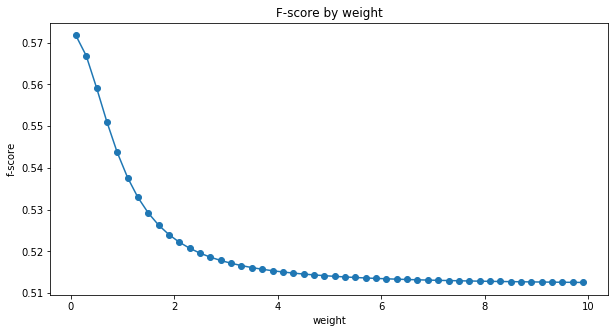

In [40]:
evaluate(y_val,y_pre,y_prob)
graph_f_score(0.1,10,0.2,y_val,y_pre)

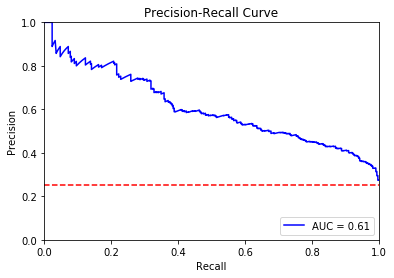

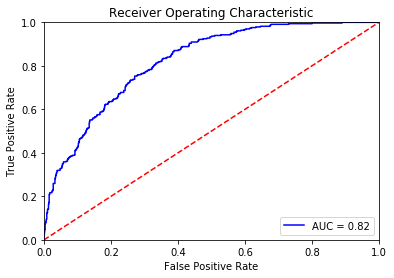

In [41]:
plot_pr_curve(y_val, y_prob)
plot_roc_curve(y_val, y_prob)

#### 4-2-3. 최적의 매개변수 구하기

In [42]:
param_grid = {'booster': ['gbtree'],
                  'objective' : ['binary:logistic'], 
                  'eval_metric' : ['error'],
                  'n_estimators':[100],
                  'max_depth': [3,5,7,9],
                  'min_child_weight':[1,3,5,7],
                  'learning_rate' : [0.01,0.05,0.1],
                  'scale_pos_weight':[1,3,5],
                  'colsample_bytree':[0.5,0.7,0.9]}

grid = GridSearchCV(estimator = xgb.XGBClassifier(), param_grid=param_grid, scoring=cri_score, verbose=1, n_jobs=-1, cv=5,)

grid_result = grid.fit(X_train_val, y_train_val)

print('best parameter : {}'.format(grid.best_params_))
print('best score of CV : {:.3f}'.format(grid.best_score_)) # 교차검증의 평균 정확도
print('best score of test set : {:.3f}'.format(grid.score(X_test,y_test))) # 최적의 매개변수와 전체 train 데이터로 만든 모델로 평가한 점수

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   39.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 10.1min
[Parallel(n_jobs=-1)]: Done 2160 out of 2160 | elapsed: 13.3min finished


best parameter : {'booster': 'gbtree', 'colsample_bytree': 0.5, 'eval_metric': 'error', 'learning_rate': 0.01, 'max_depth': 5, 'min_child_weight': 7, 'n_estimators': 100, 'objective': 'binary:logistic', 'scale_pos_weight': 5}
best score of CV : 0.747
best score of test set : 0.759


#### 4-2-4. 테스트

In [43]:
y_pred = grid_result.predict(X_test)

probs = grid_result.predict_proba(X_test)
y_prob = probs[:,1]

model_box['xgboost'] = evaluate(y_test, y_pred, y_prob)

Accuracy : 0.680887
Precision : 0.451579
Recall : 0.914712
F1 score : 0.604651
F1.5 score : 0.695300
F2 score : 0.759023
PR curve_auc score : 0.663956
ROC curve_auc score : 0.848438

Confusion Matrix : 
 [[429  40]
 [521 768]]


#### 4-2-5. 특성중요도

- weight(d) : 모든 트리에서 각 feature가 데이터를 분할하는데 사용된 횟수
- cover : weight개념에서 훈련데이터 개수에 따라 가중치를 적용받은 것
- gain : 분할에 각 변수를 사용할때마다 감소한 평균 훈련 손실

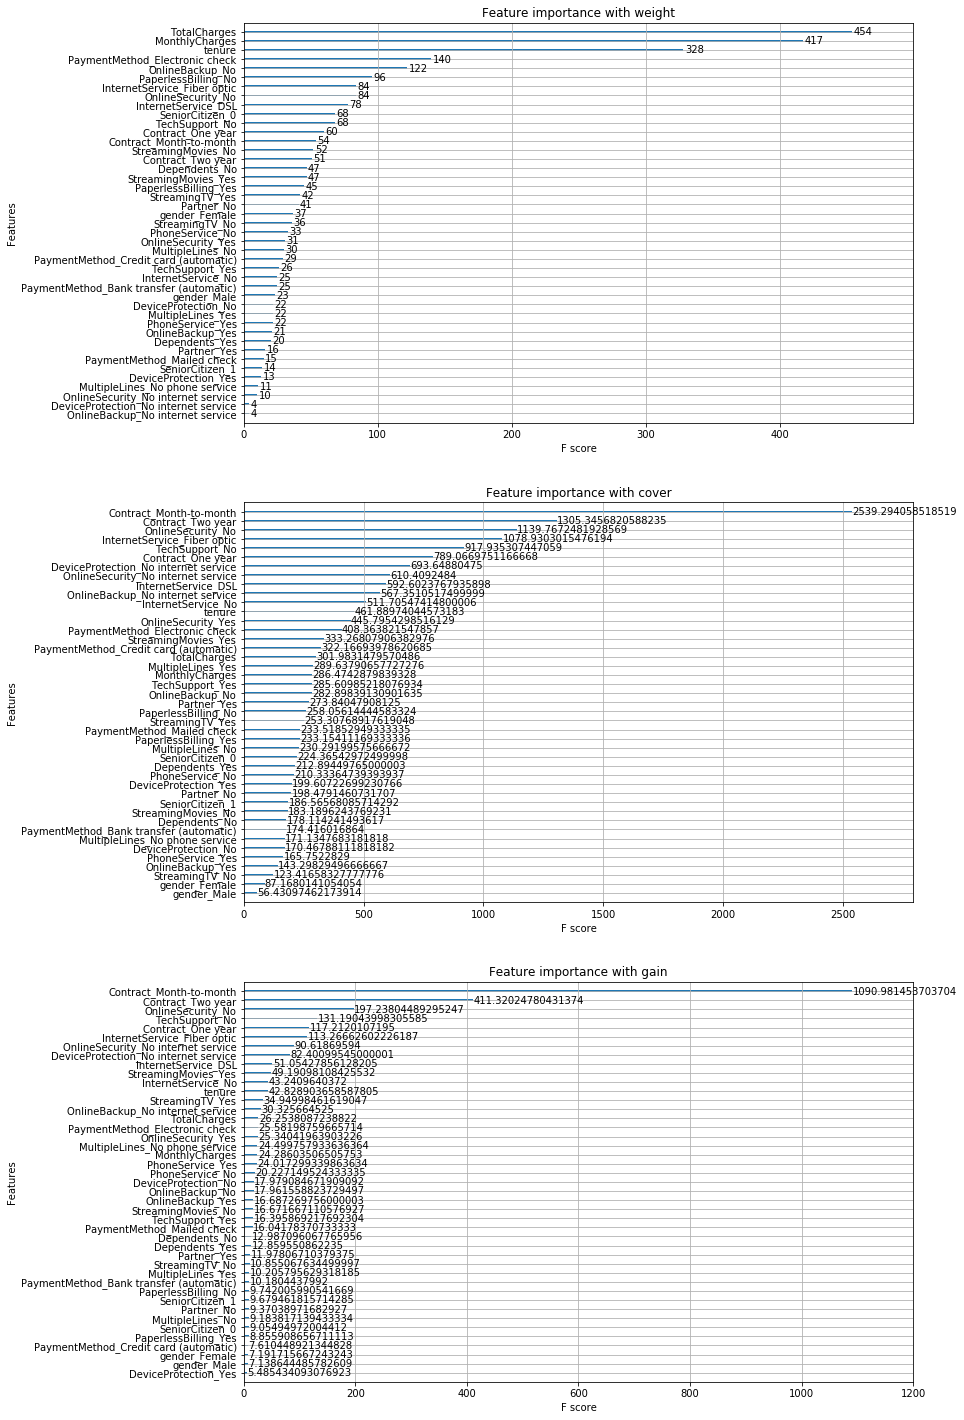

In [44]:
fig, ax = plt.subplots(3,1,figsize = (12,25))
for i, type_ in enumerate(['weight','cover','gain']):
    xgb.plot_importance(grid_result.best_estimator_,importance_type = type_, ax=ax[i])
    ax[i].set_title('Feature importance with '+type_)

## 4-3. LightGBM

- 대용량 셋에 유용함

< ROW >

Goss(Gradient Based One Side Sampling)

 : 데이터 개수를 줄일 때 큰 gradient(잔차)를 가진 데이터는 놔두고, 작은 gradient를 가진 데이터는 랜덤하게 드랍함(One side sampling의 개념)
 
 - 순서
  1. 모델을 예측함
  2. 실제값과 예측값과의 loss를 구함
  3. loss 순서대로 정렬한 후, 상위 N개는 그대로 저장(ex. 100개 중 30개면 a=0.3)
  4. 나머지 70개 중 10개만 랜덤 샘플링(b=0.1)
  5. 즉, 고 그라디언트 30개와 스몰 그라디언트 10개로 다시 샘플링 된 것
  6. 줄어든 스몰 그라디언트에 대해 weight(1-a/b)를 부여함
  7. 전체 데이터 셋에 대해 loss와 weight를 고려한 약한 예측기를 만들어 전체 데이터 셋에 추가함

< COLUMNS >

EFB(Exclusive Feature Bundling)

 : 비슷한(상호배타적이지 않은) feature들끼리는 통합하여 계산량을 줄임

#### 4-3-1. 학습 및 예측

In [45]:
lgb_model = lgb.LGBMClassifier(booster = 'gbtree',
                         objective = 'binary',
                         seed= seed)
model = lgb_model.fit(X_train, y_train)
y_pre = model.predict(X_val)

In [46]:
probs = model.predict_proba(X_val)
y_prob = probs[:,1]

#### 4-3-2. 모델 평가 (Validation set) 지표

##### - 지표 1. 정확도, 정밀도, 재현율, F1 점수

Accuracy : 0.793783
Precision : 0.605634
Recall : 0.518072
F1 score : 0.558442
F1.5 score : 0.542192
F2 score : 0.533499
PR curve_auc score : 0.626737
ROC curve_auc score : 0.833318

Confusion Matrix : 
 [[172 160]
 [112 875]]


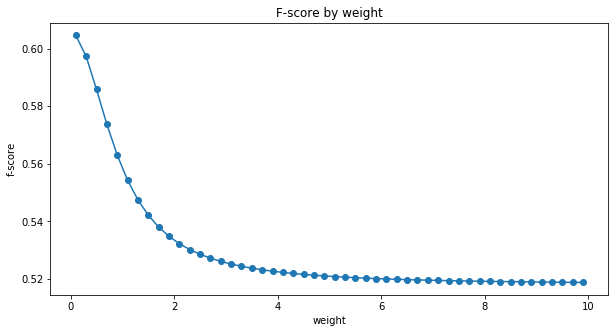

In [47]:
evaluate(y_val,y_pre,y_prob)
graph_f_score(0.1,10,0.2,y_val,y_pre)

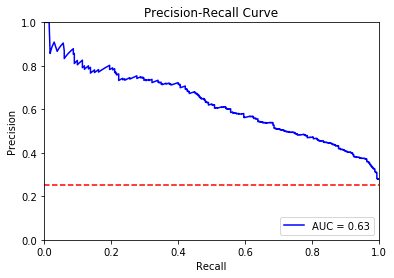

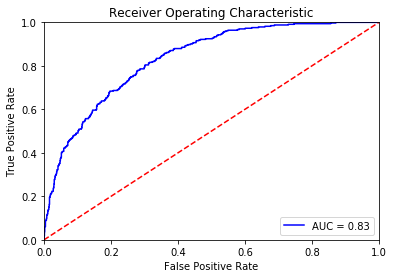

In [48]:
plot_pr_curve(y_val, y_prob)
plot_roc_curve(y_val, y_prob)

#### 4-3-3. 최적의 매개변수 구하기

In [49]:
param_grid = {'booster': ['gbtree'],
             'objective' : ['binary'],
             'learning_rate':[0.01,0.05,0.1],
              'num_leaves' : [12,15,18],
              'feature_fraction' : [0.5,0.7,0.9],
              'subsample' : [0.5,0.7,0.9],
              'min_child_weight':[1,3,5,7]
             }

grid = GridSearchCV(estimator = lgb.LGBMClassifier(), param_grid=param_grid, scoring=cri_score, verbose=1, n_jobs=-1, cv=5,)

grid_result = grid.fit(X_train_val, y_train_val)

print('best parameter : {}'.format(grid.best_params_))
print('best score of CV : {:.3f}'.format(grid.best_score_)) # 교차검증의 평균 정확도
print('best score of test set : {:.3f}'.format(grid.score(X_test,y_test))) # 최적의 매개변수와 전체 train 데이터로 만든 모델로 평가한 점수

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   22.6s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   44.2s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  1.1min


best parameter : {'booster': 'gbtree', 'feature_fraction': 0.7, 'learning_rate': 0.1, 'min_child_weight': 1, 'num_leaves': 18, 'objective': 'binary', 'subsample': 0.5}
best score of CV : 0.560
best score of test set : 0.560


[Parallel(n_jobs=-1)]: Done 1620 out of 1620 | elapsed:  1.4min finished


#### 4-3-4. 테스트

In [50]:
y_pred = grid_result.predict(X_test)

probs = grid_result.predict_proba(X_test)
y_prob = probs[:,1]

model_box['lightgbm'] = evaluate(y_test, y_pred, y_prob)

Accuracy : 0.799204
Precision : 0.647959
Recall : 0.541578
F1 score : 0.590012
F1.5 score : 0.570392
F2 score : 0.559965
PR curve_auc score : 0.665854
ROC curve_auc score : 0.844677

Confusion Matrix : 
 [[ 254  215]
 [ 138 1151]]


#### 4-3-5. 특성중요도

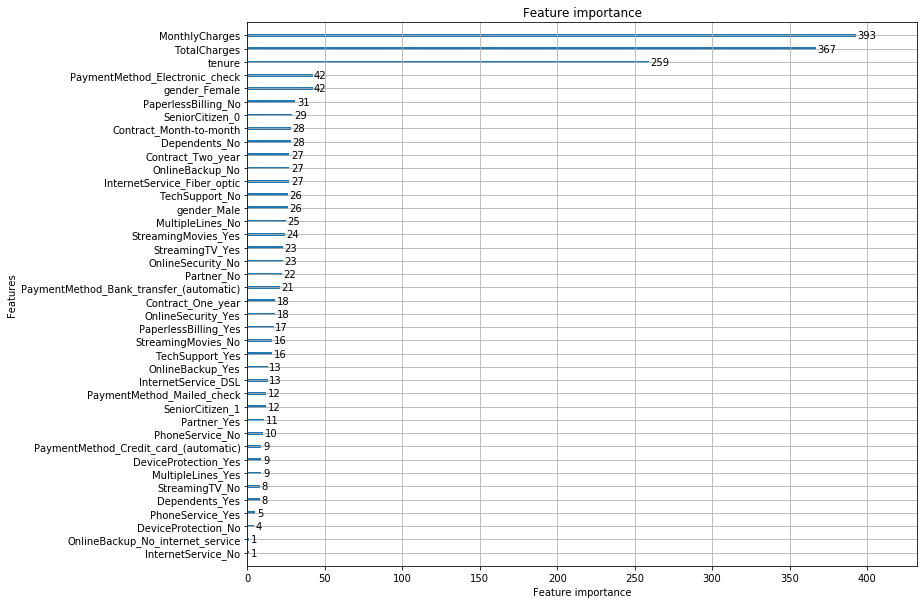

In [51]:
fig, ax = plt.subplots(1,1,figsize = (12,10))
lgb.plot_importance(grid_result.best_estimator_, ax=ax)

## 4-4. CatBoost

개념 및 특징
- 대부분 카테고리형 범주인 데이터셋에 사용
- Level wise tree
- Ordered Boost : 데이터의 일부만 가지고 잔차를 계산 후, 모델 생성.나머지 데이터의 잔차는 해당 모델로 계산.
- Random Permutation(무작위 순열) : 순서를 매번 섞어줌
- Ordered Target Encoding(=Target Encoding, Mean Encoding, Response Encoding) : 카테고리 특징의 데이터들을 해당 레이블의 예측값 평균으로 대체/ 모델학습에 사용된 target데이터만 사용. 즉, 같은 레이블이더라도 매번 대체되는 평균값이 변화됨 -> data leakage 방지
- Categorical Feature Combinations : 레이블을 예측하는데에 있어 불필요한 특성 줄여줌.
- One Hot Encoding : 자체적으로 원핫인코딩 시행, one_hot_max_size 파라미터로 기준이 되는 데이터 크기 지정
- Optimized Parameter Tuning : 굳이 튜닝하지 않아도 성능이 좋음. 하더라도 learning_rate, random_strength, L2_regulariser 이 정도 적당



#### 4-4-1. 학습 및 예측

In [52]:
cat_features = list(X_train.columns[3:])

In [53]:
cb_model = cb.CatBoostClassifier()
model = cb_model.fit(X_train, y_train,cat_features = cat_features)
y_pre = model.predict(X_val)

Learning rate set to 0.018532
0:	learn: 0.6800431	total: 83.3ms	remaining: 1m 23s
1:	learn: 0.6685506	total: 88.6ms	remaining: 44.2s
2:	learn: 0.6569669	total: 96.5ms	remaining: 32.1s
3:	learn: 0.6459188	total: 102ms	remaining: 25.3s
4:	learn: 0.6351574	total: 107ms	remaining: 21.2s
5:	learn: 0.6254241	total: 113ms	remaining: 18.8s
6:	learn: 0.6169110	total: 118ms	remaining: 16.7s
7:	learn: 0.6073044	total: 125ms	remaining: 15.5s
8:	learn: 0.5986892	total: 132ms	remaining: 14.5s
9:	learn: 0.5901767	total: 138ms	remaining: 13.6s
10:	learn: 0.5827722	total: 145ms	remaining: 13.1s
11:	learn: 0.5756545	total: 151ms	remaining: 12.5s
12:	learn: 0.5682936	total: 159ms	remaining: 12.1s
13:	learn: 0.5618820	total: 166ms	remaining: 11.7s
14:	learn: 0.5554582	total: 174ms	remaining: 11.4s
15:	learn: 0.5494438	total: 179ms	remaining: 11s
16:	learn: 0.5432848	total: 186ms	remaining: 10.7s
17:	learn: 0.5379101	total: 192ms	remaining: 10.5s
18:	learn: 0.5330394	total: 197ms	remaining: 10.2s
19:	learn

172:	learn: 0.3828962	total: 1.36s	remaining: 6.51s
173:	learn: 0.3826829	total: 1.37s	remaining: 6.5s
174:	learn: 0.3824831	total: 1.38s	remaining: 6.5s
175:	learn: 0.3823268	total: 1.39s	remaining: 6.49s
176:	learn: 0.3820549	total: 1.39s	remaining: 6.47s
177:	learn: 0.3818781	total: 1.4s	remaining: 6.46s
178:	learn: 0.3817061	total: 1.4s	remaining: 6.44s
179:	learn: 0.3815281	total: 1.42s	remaining: 6.45s
180:	learn: 0.3813729	total: 1.42s	remaining: 6.43s
181:	learn: 0.3811428	total: 1.43s	remaining: 6.42s
182:	learn: 0.3808505	total: 1.43s	remaining: 6.4s
183:	learn: 0.3806446	total: 1.44s	remaining: 6.39s
184:	learn: 0.3804527	total: 1.45s	remaining: 6.38s
185:	learn: 0.3803358	total: 1.45s	remaining: 6.36s
186:	learn: 0.3802735	total: 1.46s	remaining: 6.34s
187:	learn: 0.3801360	total: 1.46s	remaining: 6.32s
188:	learn: 0.3798157	total: 1.47s	remaining: 6.32s
189:	learn: 0.3797216	total: 1.48s	remaining: 6.3s
190:	learn: 0.3795232	total: 1.48s	remaining: 6.29s
191:	learn: 0.3793

352:	learn: 0.3533033	total: 2.57s	remaining: 4.71s
353:	learn: 0.3531084	total: 2.58s	remaining: 4.7s
354:	learn: 0.3529956	total: 2.58s	remaining: 4.69s
355:	learn: 0.3528839	total: 2.59s	remaining: 4.68s
356:	learn: 0.3526749	total: 2.59s	remaining: 4.67s
357:	learn: 0.3525604	total: 2.6s	remaining: 4.66s
358:	learn: 0.3523324	total: 2.6s	remaining: 4.65s
359:	learn: 0.3522540	total: 2.62s	remaining: 4.66s
360:	learn: 0.3521377	total: 2.63s	remaining: 4.65s
361:	learn: 0.3520034	total: 2.63s	remaining: 4.64s
362:	learn: 0.3518956	total: 2.64s	remaining: 4.63s
363:	learn: 0.3516680	total: 2.65s	remaining: 4.62s
364:	learn: 0.3514929	total: 2.65s	remaining: 4.61s
365:	learn: 0.3514151	total: 2.66s	remaining: 4.61s
366:	learn: 0.3512442	total: 2.67s	remaining: 4.6s
367:	learn: 0.3511504	total: 2.67s	remaining: 4.59s
368:	learn: 0.3510316	total: 2.69s	remaining: 4.59s
369:	learn: 0.3508216	total: 2.69s	remaining: 4.58s
370:	learn: 0.3506907	total: 2.7s	remaining: 4.58s
371:	learn: 0.350

528:	learn: 0.3298326	total: 3.78s	remaining: 3.37s
529:	learn: 0.3297130	total: 3.79s	remaining: 3.36s
530:	learn: 0.3295893	total: 3.79s	remaining: 3.35s
531:	learn: 0.3294452	total: 3.8s	remaining: 3.34s
532:	learn: 0.3292944	total: 3.81s	remaining: 3.33s
533:	learn: 0.3291702	total: 3.81s	remaining: 3.33s
534:	learn: 0.3290447	total: 3.82s	remaining: 3.32s
535:	learn: 0.3289492	total: 3.83s	remaining: 3.31s
536:	learn: 0.3288586	total: 3.83s	remaining: 3.3s
537:	learn: 0.3287106	total: 3.84s	remaining: 3.3s
538:	learn: 0.3285700	total: 3.84s	remaining: 3.29s
539:	learn: 0.3284623	total: 3.85s	remaining: 3.28s
540:	learn: 0.3282357	total: 3.86s	remaining: 3.27s
541:	learn: 0.3281286	total: 3.86s	remaining: 3.26s
542:	learn: 0.3280394	total: 3.87s	remaining: 3.26s
543:	learn: 0.3278814	total: 3.88s	remaining: 3.25s
544:	learn: 0.3277757	total: 3.89s	remaining: 3.25s
545:	learn: 0.3276864	total: 3.9s	remaining: 3.24s
546:	learn: 0.3276021	total: 3.91s	remaining: 3.23s
547:	learn: 0.32

709:	learn: 0.3098885	total: 5s	remaining: 2.04s
710:	learn: 0.3097178	total: 5s	remaining: 2.03s
711:	learn: 0.3095790	total: 5.01s	remaining: 2.03s
712:	learn: 0.3094211	total: 5.02s	remaining: 2.02s
713:	learn: 0.3093596	total: 5.02s	remaining: 2.01s
714:	learn: 0.3092604	total: 5.03s	remaining: 2s
715:	learn: 0.3091998	total: 5.04s	remaining: 2s
716:	learn: 0.3090779	total: 5.04s	remaining: 1.99s
717:	learn: 0.3089222	total: 5.05s	remaining: 1.98s
718:	learn: 0.3088038	total: 5.05s	remaining: 1.98s
719:	learn: 0.3087389	total: 5.06s	remaining: 1.97s
720:	learn: 0.3086700	total: 5.07s	remaining: 1.96s
721:	learn: 0.3085880	total: 5.07s	remaining: 1.95s
722:	learn: 0.3084393	total: 5.08s	remaining: 1.95s
723:	learn: 0.3083344	total: 5.09s	remaining: 1.94s
724:	learn: 0.3081580	total: 5.09s	remaining: 1.93s
725:	learn: 0.3080360	total: 5.1s	remaining: 1.92s
726:	learn: 0.3079859	total: 5.1s	remaining: 1.92s
727:	learn: 0.3078955	total: 5.11s	remaining: 1.91s
728:	learn: 0.3078080	tota

890:	learn: 0.2916744	total: 6.21s	remaining: 760ms
891:	learn: 0.2915580	total: 6.22s	remaining: 753ms
892:	learn: 0.2914925	total: 6.23s	remaining: 746ms
893:	learn: 0.2914687	total: 6.24s	remaining: 739ms
894:	learn: 0.2913578	total: 6.24s	remaining: 732ms
895:	learn: 0.2912883	total: 6.25s	remaining: 725ms
896:	learn: 0.2912264	total: 6.25s	remaining: 718ms
897:	learn: 0.2910922	total: 6.26s	remaining: 711ms
898:	learn: 0.2910732	total: 6.27s	remaining: 704ms
899:	learn: 0.2909653	total: 6.27s	remaining: 697ms
900:	learn: 0.2908993	total: 6.28s	remaining: 690ms
901:	learn: 0.2908116	total: 6.28s	remaining: 683ms
902:	learn: 0.2907578	total: 6.29s	remaining: 676ms
903:	learn: 0.2906169	total: 6.3s	remaining: 669ms
904:	learn: 0.2905683	total: 6.3s	remaining: 662ms
905:	learn: 0.2904137	total: 6.31s	remaining: 655ms
906:	learn: 0.2903160	total: 6.32s	remaining: 648ms
907:	learn: 0.2901918	total: 6.33s	remaining: 641ms
908:	learn: 0.2901509	total: 6.33s	remaining: 634ms
909:	learn: 0.

In [54]:
probs = model.predict_proba(X_val)
y_prob = probs[:,1]

#### 4-4-2. 모델 평가 (Validation set) 지표

##### - 지표 1. 정확도, 정밀도, 재현율, F1 점수

Accuracy : 0.796816
Precision : 0.617647
Recall : 0.506024
F1 score : 0.556291
F1.5 score : 0.535819
F2 score : 0.525000
PR curve_auc score : 0.625615
ROC curve_auc score : 0.838234

Confusion Matrix : 
 [[168 164]
 [104 883]]


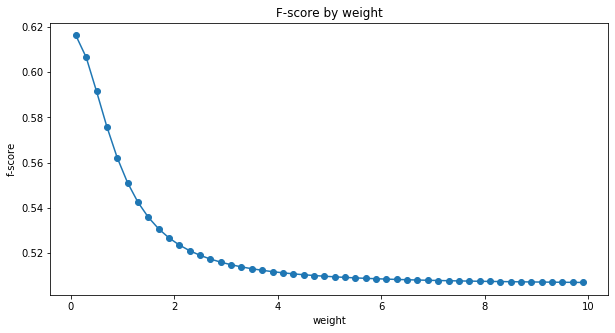

In [55]:
evaluate(y_val,y_pre,y_prob)
graph_f_score(0.1,10,0.2,y_val,y_pre)

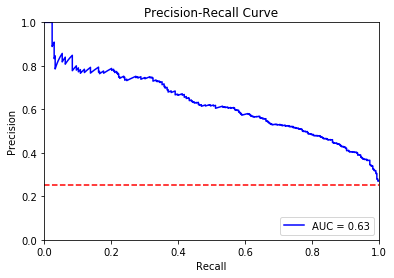

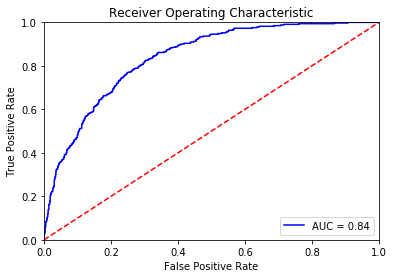

In [56]:
plot_pr_curve(y_val, y_prob)
plot_roc_curve(y_val, y_prob)

#### 4-4-3. 최적의 매개변수 구하기

In [57]:
param_grid = {'depth': [4, 7, 10],
              'iterations' : [5, 10], 
              'learning_rate' : [0.03, 0.1, 0.15],
              'l2_leaf_reg': [1,4,9],
              'iterations': [300]
             }

grid = GridSearchCV(estimator = cb.CatBoostClassifier(), param_grid=param_grid, scoring=cri_score, verbose=1, n_jobs=-1, cv=5,)

grid_result = grid.fit(X_train_val, y_train_val,cat_features = cat_features)

print('best parameter : {}'.format(grid.best_params_))
print('best score of CV : {:.3f}'.format(grid.best_score_)) # 교차검증의 평균 정확도
print('best score of test set : {:.3f}'.format(grid.score(X_test,y_test))) # 최적의 매개변수와 전체 train 데이터로 만든 모델로 평가한 점수

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed: 13.4min finished


0:	learn: 0.6741515	total: 4.29ms	remaining: 1.28s
1:	learn: 0.6566023	total: 8.43ms	remaining: 1.26s
2:	learn: 0.6390679	total: 12ms	remaining: 1.19s
3:	learn: 0.6233569	total: 15.6ms	remaining: 1.16s
4:	learn: 0.6095747	total: 19.3ms	remaining: 1.14s
5:	learn: 0.5964142	total: 23.2ms	remaining: 1.13s
6:	learn: 0.5835526	total: 26.8ms	remaining: 1.12s
7:	learn: 0.5722545	total: 30.6ms	remaining: 1.11s
8:	learn: 0.5611686	total: 34.3ms	remaining: 1.11s
9:	learn: 0.5524730	total: 38.1ms	remaining: 1.1s
10:	learn: 0.5434831	total: 41.8ms	remaining: 1.1s
11:	learn: 0.5353588	total: 45.5ms	remaining: 1.09s
12:	learn: 0.5283093	total: 49.1ms	remaining: 1.08s
13:	learn: 0.5209330	total: 52.7ms	remaining: 1.08s
14:	learn: 0.5147859	total: 56.2ms	remaining: 1.07s
15:	learn: 0.5087430	total: 59.8ms	remaining: 1.06s
16:	learn: 0.5037960	total: 63.4ms	remaining: 1.06s
17:	learn: 0.4991836	total: 67.3ms	remaining: 1.05s
18:	learn: 0.4951040	total: 70.9ms	remaining: 1.05s
19:	learn: 0.4909303	total

189:	learn: 0.3951203	total: 865ms	remaining: 501ms
190:	learn: 0.3950384	total: 869ms	remaining: 496ms
191:	learn: 0.3948831	total: 873ms	remaining: 491ms
192:	learn: 0.3947492	total: 878ms	remaining: 487ms
193:	learn: 0.3947080	total: 883ms	remaining: 482ms
194:	learn: 0.3946223	total: 888ms	remaining: 478ms
195:	learn: 0.3945251	total: 892ms	remaining: 473ms
196:	learn: 0.3944344	total: 897ms	remaining: 469ms
197:	learn: 0.3943765	total: 901ms	remaining: 464ms
198:	learn: 0.3942709	total: 905ms	remaining: 459ms
199:	learn: 0.3941312	total: 909ms	remaining: 455ms
200:	learn: 0.3940899	total: 913ms	remaining: 450ms
201:	learn: 0.3940274	total: 920ms	remaining: 446ms
202:	learn: 0.3939111	total: 924ms	remaining: 441ms
203:	learn: 0.3937755	total: 928ms	remaining: 437ms
204:	learn: 0.3937066	total: 932ms	remaining: 432ms
205:	learn: 0.3936469	total: 936ms	remaining: 427ms
206:	learn: 0.3935360	total: 941ms	remaining: 423ms
207:	learn: 0.3934127	total: 945ms	remaining: 418ms
208:	learn: 

#### 4-4-4. 테스트

In [58]:
y_pred = grid_result.predict(X_test)

probs = grid_result.predict_proba(X_test)
y_prob = probs[:,1]

model_box['catboost'] = evaluate(y_test, y_pred, y_prob)

Accuracy : 0.810011
Precision : 0.680965
Recall : 0.541578
F1 score : 0.603325
F1.5 score : 0.577980
F2 score : 0.564695
PR curve_auc score : 0.680204
ROC curve_auc score : 0.851276

Confusion Matrix : 
 [[ 254  215]
 [ 119 1170]]


In [59]:
model_box

logistic   xgboost  lightgbm  catboost
accuracy    0.811149  0.680887  0.799204  0.810011
precision   0.673418  0.451579  0.647959  0.680965
recall      0.567164  0.914712  0.541578  0.541578
f1 score    0.615741  0.604651  0.590012  0.603325
f1.5 score  0.596104  0.695300  0.570392  0.577980
f2 score    0.585645  0.759023  0.559965  0.564695
pr_auc      0.659619  0.663956  0.665854  0.680204
roc_auc     0.847287  0.848438  0.844677  0.851276